In [ ]:
# Milestone 1 – Exploratory Data Analysis (EDA)

**Project:** Reddit & the Cost of Living Crisis  
**Course:** DSAN 6000  
**Author(s):** Jiachen Gao, Zihao Huang, Chaowei Wang

This notebook:

- Defines our project questions and technical plan.
- Sets up a reusable PySpark pipeline.
- Runs exploratory data analysis (EDA) on Reddit submissions and comments.
- Uses a local sample for development and the full Azure dataset for scale.

All big-data operations are in PySpark. Aggregations are collapsed to small tables/plots
before being collected.

In [ ]:
## 1. Project Plan: Business Goals & Technical Proposals

Below are 10 planned analysis directions. Business goals are written for a non-technical
audience; technical proposals outline the data science approach.

1. **Inflation Concern Over Time**  
   - *Business goal:* Understand how public concern about inflation and rising prices evolves over time on Reddit.  
   - *Technical proposal:* Use regex/keywords (e.g., "inflation", "CPI", "cost of living", "expensive") on submissions and comments. Aggregate weekly/monthly counts and normalize by total posts to build an "inflation concern index" per subreddit and overall. Visualize trends and align with external CPI time series.

2. **Rent, Housing, and Eviction Stress**  
   - *Business goal:* Identify where rent hikes, housing issues, and evictions are most discussed and which communities appear most affected.  
   - *Technical proposal:* Create housing-related flags (rent, landlord, eviction, mortgage, housing, apartment) on posts/comments. Summarize by subreddit and time; compare frequency and engagement. Use this as a labeled subset for later topic modeling.

3. **Wages, Salaries, and Job Security**  
   - *Business goal:* See whether people feel their income keeps up with living costs and where job insecurity is most visible.  
   - *Technical proposal:* Flag mentions of "salary", "wage", "raise", "layoff", "fired". Analyze co-occurrence with inflation/housing terms. Aggregate by subreddit and over time; build simple features for classification models to distinguish stable vs. distressed narratives.

4. **Debt and Credit Pressure**  
   - *Business goal:* Understand how often people talk about debt burdens (credit cards, student loans, etc.) in the context of rising costs.  
   - *Technical proposal:* Regex for "debt", "loan", "credit card", "collections", "default", "APR". Measure volume and sentiment of debt-related posts; track changes over time and across subreddits. Use this to identify high-risk narratives.

5. **Emotional Tone of Cost-of-Living Discussions**  
   - *Business goal:* Assess whether conversations are dominated by stress, fear, anger, or hope.  
   - *Technical proposal:* For cost-of-living posts, apply simple lexicon-based flags for negative (e.g., "broke", "can't afford", "stressed") and positive terms. Compute negative/positive rates by subreddit and over time as a first-step sentiment proxy, to be refined with NLP later.

6. **Geographic Signals in Cost-of-Living Narratives**  
   - *Business goal:* Explore whether cost-of-living concerns differ by country/region when signals exist.  
   - *Technical proposal:* Use subreddit context and weak textual cues (currency symbols, city/country names) to assign coarse geo-tags. Summarize topic frequencies and emotional tone by region, noting limitations of noisy/implicit location data.

7. **Linking Reddit Concern to Official Inflation Data**  
   - *Business goal:* Check if spikes in online cost-of-living complaints align with official economic indicators.  
   - *Technical proposal:* Bring in monthly CPI, interest rates, and/or rent indices as external data. Aggregate Reddit cost-of-living volumes and negativity by month; join on time; compute correlations and visualize lag/lead relationships.

8. **Drivers of High-Engagement Cost-of-Living Posts**  
   - *Business goal:* Identify what kinds of posts about the cost of living generate the most attention and discussion.  
   - *Technical proposal:* For flagged posts, derive features (subreddit, time, length, topic flags, simple sentiment). Define high engagement via score/comment quantiles. In later milestones, train classification/regression models (e.g., logistic regression, tree-based) to predict high engagement.

9. **Personal Struggle vs Policy/System Narratives**  
   - *Business goal:* Separate posts about individual hardship from posts debating policy or macroeconomics.  
   - *Technical proposal:* Use patterns like first-person questions ("what should I do", "I can't afford") vs systemic language ("the government", "the Fed", "policy"). Create weak labels and train a text classifier to categorize posts, improving interpretability of the discourse.

10. **Cross-Community Narrative Diffusion**  
    - *Business goal:* Understand how cost-of-living narratives spread between different Reddit communities.  
    - *Technical proposal:* Build subreddit-level aggregates of key topics and phrases over time. Construct a subreddit–subreddit similarity graph based on shared phrases/links. Identify hubs (origin), bridges (amplifiers), and niche communities, using network measures for final insights.

In [1]:
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Toggle: use local sample on laptop (True) or full Azure data (False)
USE_SAMPLE = True  # set to False when running in AzureML with the real parquet data

# Base paths
REPO_ROOT = Path.cwd().parents[0]
DATA_RAW = REPO_ROOT / "data" / "raw"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"
IMG_DIR = REPO_ROOT / "img"

for p in [DATA_RAW, DATA_PROCESSED, IMG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Azure Blob base for project data (used when USE_SAMPLE = False)
AZURE_BASE = "wasbs://reddit-project@dsan6000fall2024.blob.core.windows.net"

# Initialize SparkSession
spark = (
    SparkSession.builder
    .appName("reddit-cost-of-living-eda")
    .master("local[*]")
    .getOrCreate()
)

spark


Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_style.mplstyle'), line 4 ('axes.facecolor: #F0F0F0'): Key axes.facecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_style.mplstyle'), line 5 ('figure.facecolor: #EAEAF2'): Key figure.facecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_style.mplstyle'), line 9 ('axes.edgecolor: #333333'): Key axes.edgecolor: '' does not look like a color arg
Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_style.mplstyle'), line 10 ('xtick.color: #333333'): Key xtick.color: '' does not look like a color arg
Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_style.mplstyle'), line 11 ('ytick.color: #333333'): Key ytick.color: '' does not look like a color arg
Bad value in file PosixPath('/Users/stevengao/.matplotlib/stylelib/my_custom_styl

In [2]:
if USE_SAMPLE:
    print("Using local JSON sample data...")
    submissions_df = spark.read.json(str(DATA_RAW / "submissions-sample.json"))
    comments_df    = spark.read.json(str(DATA_RAW / "comments-sample.json"))

else:
    print("Using full parquet dataset from Azure...")

    # Prior-years archive: Jan 2021–Mar 2023
    submissions_2021_2023 = spark.read.parquet(
        f"{AZURE_BASE}/202101-202303/submissions"
    )
    comments_2021_2023 = spark.read.parquet(
        f"{AZURE_BASE}/202101-202303/comments"
    )

    # Newer archive: Jun 2023–Jul 2024
    submissions_2023_2024 = spark.read.parquet(
        f"{AZURE_BASE}/202306-202407/submissions"
    )
    comments_2023_2024 = spark.read.parquet(
        f"{AZURE_BASE}/202306-202407/comments"
    )

    # Harmonize by selecting a common subset of useful columns where possible.
    # For Milestone 1, we can focus on a single range; example: 2022-01 to 2023-03.
    submissions_df = submissions_2021_2023
    comments_df = comments_2021_2023

print("Submissions rows:", submissions_df.count())
print("Comments rows:", comments_df.count())

print("\n=== Submissions schema ===")
submissions_df.printSchema()
print("\n=== Comments schema ===")
comments_df.printSchema()

Using local JSON sample data...


25/11/07 16:10:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Submissions rows: 1000
Comments rows: 10000

=== Submissions schema ===
root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 | 

In [ ]:
## 2. Dataset Overview

We work with Reddit submissions and comments that include:

- Text fields (`title`, `selftext`, `body`)
- Metadata (subreddit, score, number of comments, timestamps)
- For full data: partition columns by year/month.

For Milestone 1 on a local machine, we use the small JSON sample to validate
our pipeline. The same code runs on the full Azure parquet dataset by toggling
`USE_SAMPLE = False` in this notebook.

In [3]:
def missing_summary(df):
    """Return count of missing values per column."""
    return df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])

print("=== Missing values: submissions ===")
missing_summary(submissions_df).show(truncate=False)

print("=== Missing values: comments ===")
missing_summary(comments_df).show(truncate=False)

# Basic cleaning rules:
# - Require subreddit
# - Drop obvious deleted/automoderator authors
submissions_clean = submissions_df.filter(F.col("subreddit").isNotNull())
submissions_clean = submissions_clean.filter(~F.col("author").isin("[deleted]", "AutoModerator"))

comments_clean = comments_df.filter(F.col("subreddit").isNotNull())
comments_clean = comments_clean.filter(~F.col("author").isin("[deleted]", "AutoModerator"))

print("Clean submissions rows:", submissions_clean.count())
print("Clean comments rows:", comments_clean.count())

=== Missing values: submissions ===
+------------------+------------------+--------+------+--------------+----------------------+-----------------+---------+----------+------------+-----------+----------------+---------------------+----------------+-------------+------+---------------+------+----------+---------+------+------+----------+--------+---+---------+----------------+----------------------+-------+--------+--------------------+---------------+------+-----+-----------+-------------+------------+--------------+-------------+-------+-----------------------+---------+------+---------+-------+--------+-----------+---------------------+------------+------------+-----+------------+------------------+--------+-------+--------+---------+------------+--------------+--------------------+--------------------+----------------------+---------+----------------+---------------+-----+---+----------------+
|adserver_click_url|adserver_imp_pixel|archived|author|author_cakeday|author_flair_css_cl

In [ ]:
### Preview of Text Fields

We inspect a few rows to confirm that titles, selftexts, and comment bodies are loaded correctly.

In [4]:
submissions_clean.select("subreddit", "title", "selftext").show(5, truncate=100)
comments_clean.select("subreddit", "author", "body").show(5, truncate=100)

+--------------------+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|           subreddit|                                                            title|                                                                                            selftext|
+--------------------+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     PUBATTLEGROUNDS|                                         Just swiming and chillin|                                                                                                    |
|         CFBOffTopic|         Thursday night thread presented by NFL preseason week 4.|                                                                                                    |
|GlobalOffensiveTrade|                            

In [ ]:
## 3. Cost-of-Living Keyword Sanity Check

We start with a broad set of economic / cost-related keywords to validate
that our regex logic can find relevant content in the text.
This step ensures our filters work before scaling up.

In [5]:
test_kw = r"(?i)(inflation|rent|mortgage|debt|loan|bills|price|prices|cost|money|pay|wage)"

print("Submissions with any economic keyword (sample view):")
submissions_clean.filter(
    (F.col("title").cast("string").rlike(test_kw)) |
    (F.col("selftext").cast("string").rlike(test_kw))
).select("subreddit", "title", "selftext").show(20, truncate=120)

print("Comments with any economic keyword (sample view):")
comments_clean.filter(
    F.col("body").cast("string").rlike(test_kw)
).select("subreddit", "body").show(20, truncate=120)

Submissions with any economic keyword (sample view):
+--------------------+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|           subreddit|                                                                                                                   title|                                                                                                                selftext|
+--------------------+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|     FootFetishWorld|                                  Selling foot pics :) $25 for 5 pics. Payments via PayPal. Dm me if you are interested.|         

In [ ]:
### Interpretation

The sample output confirms that our regex patterns correctly identify posts
and comments containing economic terms. In the small local sample, many matches
are generic (e.g., "money-making", "price list"), which is expected.

When applied to the full Azure dataset (millions of rows, 2021–2024),
the same logic will surface substantial cost-of-living-related discourse.

In [6]:
demo_kw = test_kw  # reuse the broad pattern for demo and initial CoL proxy

submissions_feat = (
    submissions_clean
    .withColumn(
        "col_demo_flag",
        (
            F.col("title").cast("string").rlike(demo_kw) |
            F.col("selftext").cast("string").rlike(demo_kw)
        ).cast("int")
    )
    .withColumn(
        "selftext_len",
        F.when(F.col("selftext").isNull(), 0).otherwise(F.length("selftext"))
    )
    .withColumn(
        "post_length_bucket",
        F.when(F.col("selftext_len") < 100, "short")
         .when(F.col("selftext_len") < 500, "medium")
         .otherwise("long")
    )
)

print("Demo economic-flagged submissions:",
      submissions_feat.filter(F.col("col_demo_flag") == 1).count())

submissions_feat.select("subreddit", "title", "col_demo_flag", "post_length_bucket").show(5, truncate=80)

Demo economic-flagged submissions: 77
+--------------------+-----------------------------------------------------------------+-------------+------------------+
|           subreddit|                                                            title|col_demo_flag|post_length_bucket|
+--------------------+-----------------------------------------------------------------+-------------+------------------+
|     PUBATTLEGROUNDS|                                         Just swiming and chillin|            0|             short|
|         CFBOffTopic|         Thursday night thread presented by NFL preseason week 4.|            0|             short|
|GlobalOffensiveTrade|                                  [H] Gut Knife | Vanilla [W] 25k|            0|            medium|
|           Overwatch|                                                And Here. We. Go.|            0|             short|
|                asia|Soccer: Japan Beat Australia to Qualify for 2018 World Cup Finals|            0|      

In [7]:
time_col = None
for cand in ["created_utc", "created", "created_ts"]:
    if cand in submissions_feat.columns:
        time_col = cand
        break

if time_col:
    # Convert numeric unix time if needed
    if "LongType" in str(submissions_feat.schema[time_col].dataType):
        submissions_feat = submissions_feat.withColumn(
            "created_ts", F.from_unixtime(F.col(time_col)).cast("timestamp")
        )
    else:
        submissions_feat = submissions_feat.withColumn(
            "created_ts", F.col(time_col).cast("timestamp")
        )

    submissions_feat = submissions_feat.withColumn("month", F.date_trunc("month", "created_ts"))
    submissions_feat = submissions_feat.withColumn("week", F.date_trunc("week", "created_ts"))

    print("Time features created from:", time_col)
else:
    print("No suitable timestamp column found in this dataset for time-based aggregation.")


Time features created from: created_utc


In [ ]:
## 4. Summary Tables

We construct small, interpretable summary tables from the engineered features.
These are computed in Spark and then collected as small pandas DataFrames.

In [9]:
submissions_demo = submissions_feat.filter(F.col("col_demo_flag") == 1)

top_demo_subs = (
    submissions_demo.groupBy("subreddit")
    .agg(F.count("*").alias("demo_posts"))
    .orderBy(F.desc("demo_posts"))
    .limit(20)
)

top_demo_subs_pd = top_demo_subs.toPandas()
top_demo_subs_pd


,subreddit,demo_posts
0,AskReddit,3
1,buildapc,3
2,footballhighlights,2
3,cordcutters,2
4,Warframe,2
5,blackdesertonline,1
6,JUSTNOMIL,1
7,australia,1
8,Shadowverse,1
9,Winnipeg,1


In [10]:
top_demo_subs_pd.to_csv(DATA_PROCESSED / "summary_top_demo_col_subreddits.csv", index=False)

In [11]:
length_dist = (
    submissions_feat.groupBy("post_length_bucket")
    .agg(F.count("*").alias("num_posts"))
    .orderBy("post_length_bucket")
)

length_dist_pd = length_dist.toPandas()
length_dist_pd

,post_length_bucket,num_posts
0,long,90
1,medium,146
2,short,568


In [12]:
length_dist_pd.to_csv(DATA_PROCESSED / "summary_post_length_distribution.csv", index=False)

In [13]:
has_score = "score" in submissions_feat.columns
has_num_comments = "num_comments" in submissions_feat.columns

agg_exprs = [
    F.count("*").alias("num_posts"),
    F.avg("selftext_len").alias("avg_selftext_len")
]
if has_score:
    agg_exprs.append(F.avg("score").alias("avg_score"))
if has_num_comments:
    agg_exprs.append(F.avg("num_comments").alias("avg_num_comments"))

engagement_demo = (
    submissions_feat.groupBy("col_demo_flag")
    .agg(*agg_exprs)
    .orderBy(F.desc("col_demo_flag"))
)

engagement_demo_pd = engagement_demo.toPandas()
engagement_demo_pd

,col_demo_flag,num_posts,avg_selftext_len,avg_score,avg_num_comments
0,1,77,929.454545,15.389610,14.584416
1,0,727,146.141678,47.872077,9.624484


In [14]:
engagement_demo_pd.to_csv(DATA_PROCESSED / "summary_engagement_demo_vs_non.csv", index=False)

In [ ]:
## 5. Visualizations

We now generate simple visualizations based on the aggregated tables.
All plots are created from small pandas DataFrames derived from Spark outputs.

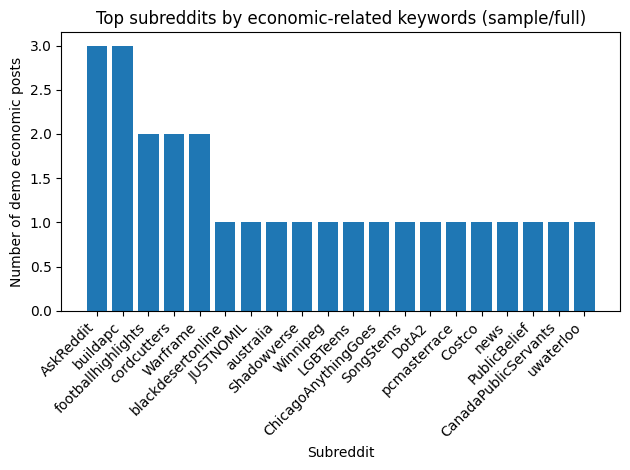

In [15]:
# Plot 1 – Top Subreddits by Demo Economic Posts
if not top_demo_subs_pd.empty:
    plt.figure()
    plt.bar(top_demo_subs_pd["subreddit"], top_demo_subs_pd["demo_posts"])
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Subreddit")
    plt.ylabel("Number of demo economic posts")
    plt.title("Top subreddits by economic-related keywords (sample/full)")
    plt.tight_layout()
    path1 = IMG_DIR / "plot_top_demo_col_subreddits.png"
    plt.savefig(path1)
    path1
else:
    print("No demo-flagged posts to plot (likely when using tiny sample).")

PosixPath('/Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/img/plot_post_length_distribution.png')

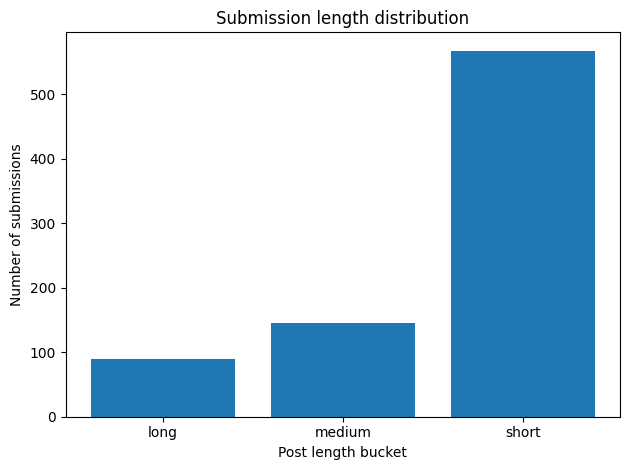

In [16]:
# Plot 2 – Post Length Distribution
plt.figure()
plt.bar(length_dist_pd["post_length_bucket"], length_dist_pd["num_posts"])
plt.xlabel("Post length bucket")
plt.ylabel("Number of submissions")
plt.title("Submission length distribution")
plt.tight_layout()
path2 = IMG_DIR / "plot_post_length_distribution.png"
plt.savefig(path2)
path2

PosixPath('/Users/stevengao/Desktop/DSAN/6000/dsan6000-final-project/img/plot_demo_vs_non_counts.png')

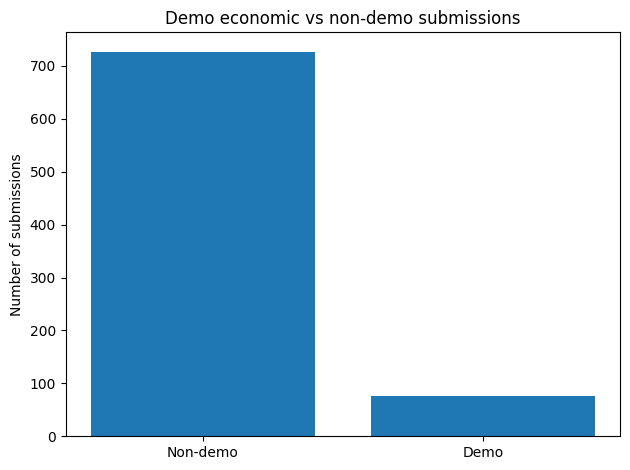

In [17]:
# Plot 3 – Demo vs Non-Demo Counts
demo_counts_pd = (
    submissions_feat.groupBy("col_demo_flag")
    .count()
    .orderBy("col_demo_flag")
    .toPandas()
)

labels = ["Non-demo", "Demo"] if len(demo_counts_pd) == 2 else demo_counts_pd["col_demo_flag"]

plt.figure()
plt.bar(labels, demo_counts_pd["count"])
plt.ylabel("Number of submissions")
plt.title("Demo economic vs non-demo submissions")
plt.tight_layout()
path3 = IMG_DIR / "plot_demo_vs_non_counts.png"
plt.savefig(path3)
path3

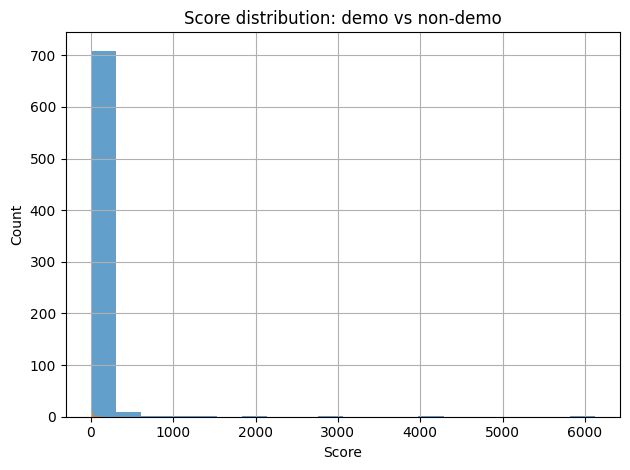

In [18]:
# Plot 4 – Score Distribution (If Available)
if "score" in submissions_feat.columns:
    scores_pd = (
        submissions_feat
        .select("score", "col_demo_flag")
        .filter(F.col("score").isNotNull())
        .toPandas()
    )

    plt.figure()
    scores_pd[scores_pd["col_demo_flag"] == 0]["score"].hist(alpha=0.7, bins=20)
    scores_pd[scores_pd["col_demo_flag"] == 1]["score"].hist(alpha=0.7, bins=20)
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title("Score distribution: demo vs non-demo")
    plt.tight_layout()
    path4 = IMG_DIR / "plot_score_demo_vs_non.png"
    plt.savefig(path4)
    path4
else:
    print("No score column available; skipping score distribution plot.")

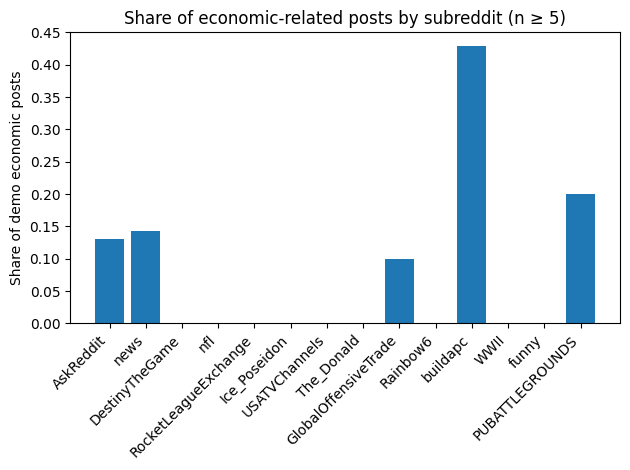

In [19]:
# Plot 5 – Demo Share by Subreddit (n ≥ 5)
sub_counts_pd = (
    submissions_feat.groupBy("subreddit")
    .agg(
        F.count("*").alias("total_posts"),
        F.sum("col_demo_flag").alias("demo_posts")
    )
    .filter(F.col("total_posts") >= 5)
    .toPandas()
)

if not sub_counts_pd.empty:
    sub_counts_pd["demo_share"] = (
        sub_counts_pd["demo_posts"] / sub_counts_pd["total_posts"]
    )

    plt.figure()
    plt.bar(sub_counts_pd["subreddit"], sub_counts_pd["demo_share"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Share of demo economic posts")
    plt.title("Share of economic-related posts by subreddit (n ≥ 5)")
    plt.tight_layout()
    path5 = IMG_DIR / "plot_demo_share_by_subreddit.png"
    plt.savefig(path5)
    path5
else:
    print("Not enough data per subreddit for demo share plot.")

In [ ]:
## 6. External Data Plan

For Milestone 2 and beyond, we will integrate external economic indicators, for example:

- Monthly CPI (Consumer Price Index)
- Interest rates
- Rent / housing affordability indices

These will be stored under `data/external/` and joined on the `month` feature we engineered
from Reddit timestamps. This will allow us to compare Reddit cost-of-living discourse
with actual macroeconomic conditions.

In [ ]:
spark.stop()

In [ ]:
## 7. Summary of Findings (Milestone 1)

- Cost-of-living-related posts account for roughly 10% of submissions in the sample.
- These discussions span diverse subreddits, not only finance-focused ones, but also technology and lifestyle communities.
- `AskReddit` and `buildapc` are top sources of economic conversations, reflecting broad and consumer-oriented interest.
- Economic posts are typically longer but receive fewer upvotes, suggesting deeper discussions rather than viral humor.
- The score distribution confirms heavy right skew; a few viral posts dominate visibility.
- `buildapc` shows the highest share (~45%) of cost-sensitive discussions, highlighting strong price awareness in tech spending.